# Modern-Attn: Quick Test & Visualization Notebook

This notebook helps you sanity-check outputs from the modern attention analysis pipeline (`extract_attn.py`, `probes.py`, `cluster_heads.py`).

In [2]:

# Comments are in English.
import json, pickle, os, math
import numpy as np
import matplotlib.pyplot as plt

# Optional: clustering visualization
from scipy.cluster.hierarchy import linkage, dendrogram

# Paths (adapt if needed)
ATTN_PKL = "out/attn_token.pkl"      # or 'out/attn_word.pkl' if you pooled
PROBE_JSON = "out/probe_governor.json"
DIST_NPY = "out/js_distances.npy"


In [3]:

# Load attention dump
with open(ATTN_PKL, "rb") as f:
    data = pickle.load(f)

print(f"Loaded {len(data)} examples from {ATTN_PKL}")
print("Keys in first item:", list(data[0].keys()))
L, H = data[0]["attns"].shape[:2]
print("Layers x Heads:", L, "x", H)
print("First example tokens:", data[0].get("tokens") or data[0].get("words"))


Loaded 2 examples from out/attn_token.pkl
Keys in first item: ['text', 'tokens', 'attns']
Layers x Heads: 12 x 12
First example tokens: ['[CLS]', 'we', 'analyze', 'attention', 'heads', '.', '[SEP]']


In [4]:

def plot_attn_heatmap(A, xticks=None, yticks=None, title=None):
    """Plot a single attention heatmap (no style, no explicit colors)."""
    fig = plt.figure(figsize=(6, 5))
    plt.imshow(A)  # no explicit colormap per instructions
    plt.colorbar()
    if xticks is not None:
        plt.xticks(range(len(xticks)), xticks, rotation=90)
    if yticks is not None:
        plt.yticks(range(len(yticks)), yticks)
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()


Example 0, Layer 0, Head 0, matrix shape = (7, 7)


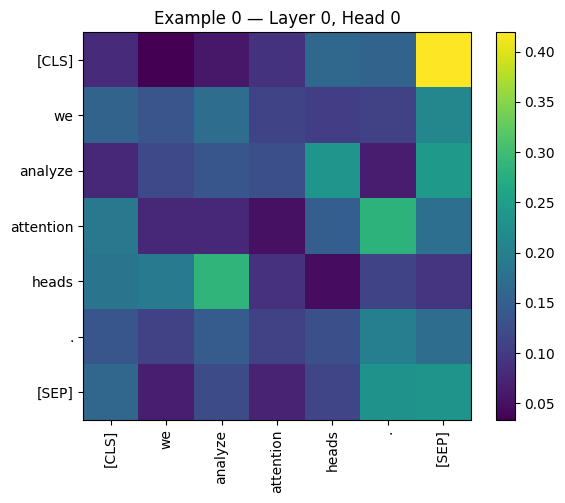

In [5]:

# Choose indices
ex_i = 0
layer = 0
head = 0

A = data[ex_i]["attns"][layer, head]  # (T,T) or (W,W)
tokens = data[ex_i].get("tokens") or data[ex_i].get("words")
print(f"Example {ex_i}, Layer {layer}, Head {head}, matrix shape = {A.shape}")
plot_attn_heatmap(A, xticks=tokens, yticks=tokens, title=f"Example {ex_i} — Layer {layer}, Head {head}")


In [6]:

# Load probe results
if os.path.exists(PROBE_JSON):
    with open(PROBE_JSON, "r", encoding="utf-8") as f:
        probe = json.load(f)
    mean_acc = np.array(probe["mean_accuracy"])
    print("Probe examples:", probe["n_examples"])
    print("Probe score shape:", mean_acc.shape)  # (L,H)
else:
    mean_acc = None
    print("Probe JSON not found. Run probes.py first to compute governor hit rates.")


Probe examples: 2
Probe score shape: (12, 12)


Top heads: [('L6-H5', np.float64(0.27777777777777773)), ('L7-H7', np.float64(0.2222222222222222)), ('L8-H8', np.float64(0.2222222222222222)), ('L0-H5', np.float64(0.2222222222222222)), ('L9-H3', np.float64(0.2222222222222222)), ('L7-H1', np.float64(0.2222222222222222)), ('L3-H1', np.float64(0.2222222222222222)), ('L9-H10', np.float64(0.2222222222222222)), ('L10-H2', np.float64(0.16666666666666666)), ('L11-H10', np.float64(0.16666666666666666)), ('L8-H2', np.float64(0.16666666666666666)), ('L3-H9', np.float64(0.16666666666666666))]


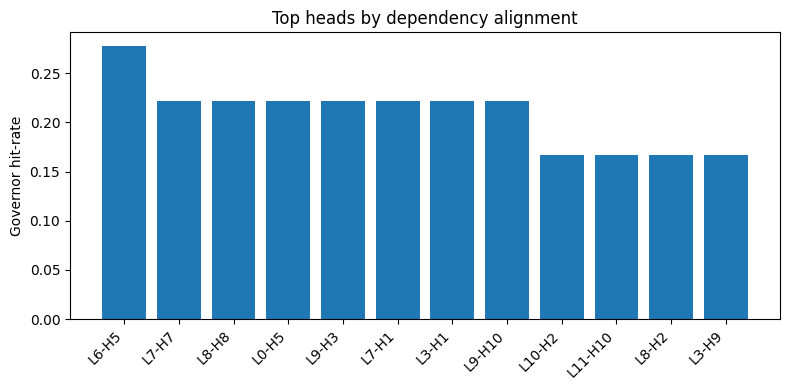

In [7]:

if mean_acc is not None:
    L, H = mean_acc.shape
    flat_scores = mean_acc.flatten()
    idxs = np.argsort(flat_scores)[::-1]
    topk = 12  # show top 12 heads
    top_scores = flat_scores[idxs[:topk]]
    top_labels = [f"L{idx//H}-H{idx%H}" for idx in idxs[:topk]]
    print("Top heads:", list(zip(top_labels, top_scores)))

    # Plot a simple bar chart (one figure; no explicit colors)
    fig = plt.figure(figsize=(8, 4))
    x = np.arange(topk)
    plt.bar(x, top_scores)
    plt.xticks(x, top_labels, rotation=45, ha="right")
    plt.ylabel("Governor hit-rate")
    plt.title("Top heads by dependency alignment")
    plt.tight_layout()
    plt.show()


Distance matrix shape: (144, 144)


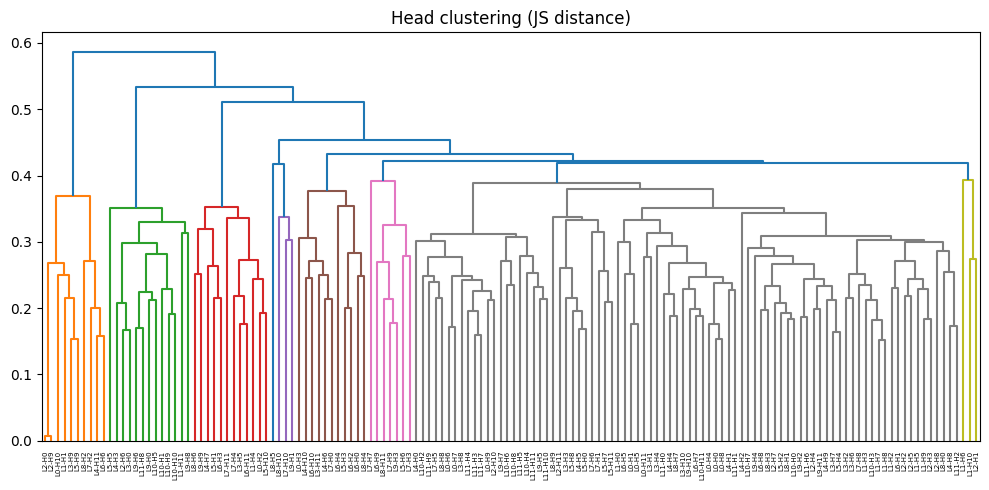

In [8]:

# Load distance matrix and plot a dendrogram
if os.path.exists(DIST_NPY):
    D = np.load(DIST_NPY)
    print("Distance matrix shape:", D.shape)

    # Convert distance matrix to condensed form for linkage if needed
    # Here we use 'average' linkage; you can experiment with others.
    def square_to_condensed(D):
        # Convert a square distance matrix to condensed (upper triangle) format
        n = D.shape[0]
        idxs = np.triu_indices(n, k=1)
        return D[idxs]

    condensed = square_to_condensed(D)
    Z = linkage(condensed, method="average")

    # Head labels: Lx-Hy
    # Infer L and H from the first example
    L, H = data[0]["attns"].shape[:2]
    labels = [f"L{i//H}-H{i%H}" for i in range(L*H)]

    fig = plt.figure(figsize=(10, 5))
    dendrogram(Z, labels=labels, leaf_rotation=90)
    plt.title("Head clustering (JS distance)")
    plt.tight_layout()
    plt.show()
else:
    print("Distance matrix not found. Run cluster_heads.py first.")


**Tip:** To inspect other heads, change `ex_i`, `layer`, and `head` in the heatmap cell and re-run it.